<a href="https://www.kaggle.com/code/nisarbalti/5-flower-classification-vgg16-95?scriptVersionId=134928693" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

#                                5 Flower Classification with VGG16 with val_acc > 95%
In this project, we implemented a flower classification model using transfer learning with the VGG16 architecture. The goal was to classify images of different flower types into five categories: Tulip, Lilly, Lotus, Orchid, and Sunflower.

## Importing importent Libraries 

Importing the necessary libraries for building the model and working with images. The libraries include Keras, TensorFlow, PIL, Matplotlib, NumPy, Pandas, shutil, etc. These libraries provide functions and tools for deep learning, image processing, data manipulation, and visualization. Some specific modules and functions are imported from these libraries.

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import  Dense, Flatten, MaxPooling2D 
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint

from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.image as img
import os
import numpy as np
import shutil
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## **Downloading Dataset and splitting into Train and Test Sets**
The code downloads the dataset from the specified path and splits it into train and test sets. The dataset contains images of different flower types, and the classes are defined in the 'classes_dir' list. The code creates directories for each class in the train and test sets and copies the respective images to these directories.


In [2]:

path = '/kaggle/input/5-flower-types-classification-dataset/flower_images'

rootdir = '/kaggle/working/'
classes_dir = ['Tulip', 'Lilly', 'Lotus', 'Orchid', 'Sunflower'] #total labels
for i in classes_dir:
    if not os.path.exists(rootdir +'/train/' + i):
        os.makedirs(rootdir +'/train/' + i)
    if not os.path.exists(rootdir +'/test/' + i):
        os.makedirs(rootdir +'/test/' + i)

    source = path + '/' + i

    allFileNames = os.listdir(source)

    np.random.shuffle(allFileNames)

    test_ratio = 0.20

    train_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)* (1 - test_ratio))])

    train_FileNames = [source+'/'+ name for name in train_FileNames.tolist()]
    test_FileNames = [source+'/' + name for name in test_FileNames.tolist()]

    for name in train_FileNames:
      shutil.copy(name, rootdir +'/train/' + i)

    for name in test_FileNames:
      shutil.copy(name, rootdir +'/test/' + i)



## Train and Test Sets Path Settings
The paths for the train and test sets are set using the 'rootdir' variable. The train set path is set as 'rootdir + 'train'' and the test set path is set as 'rootdir + 'test''.


In [3]:
#Setting dataset path for train and test sets 
train_path = rootdir + 'train'
test_path = rootdir + 'test'

## Data Visualization

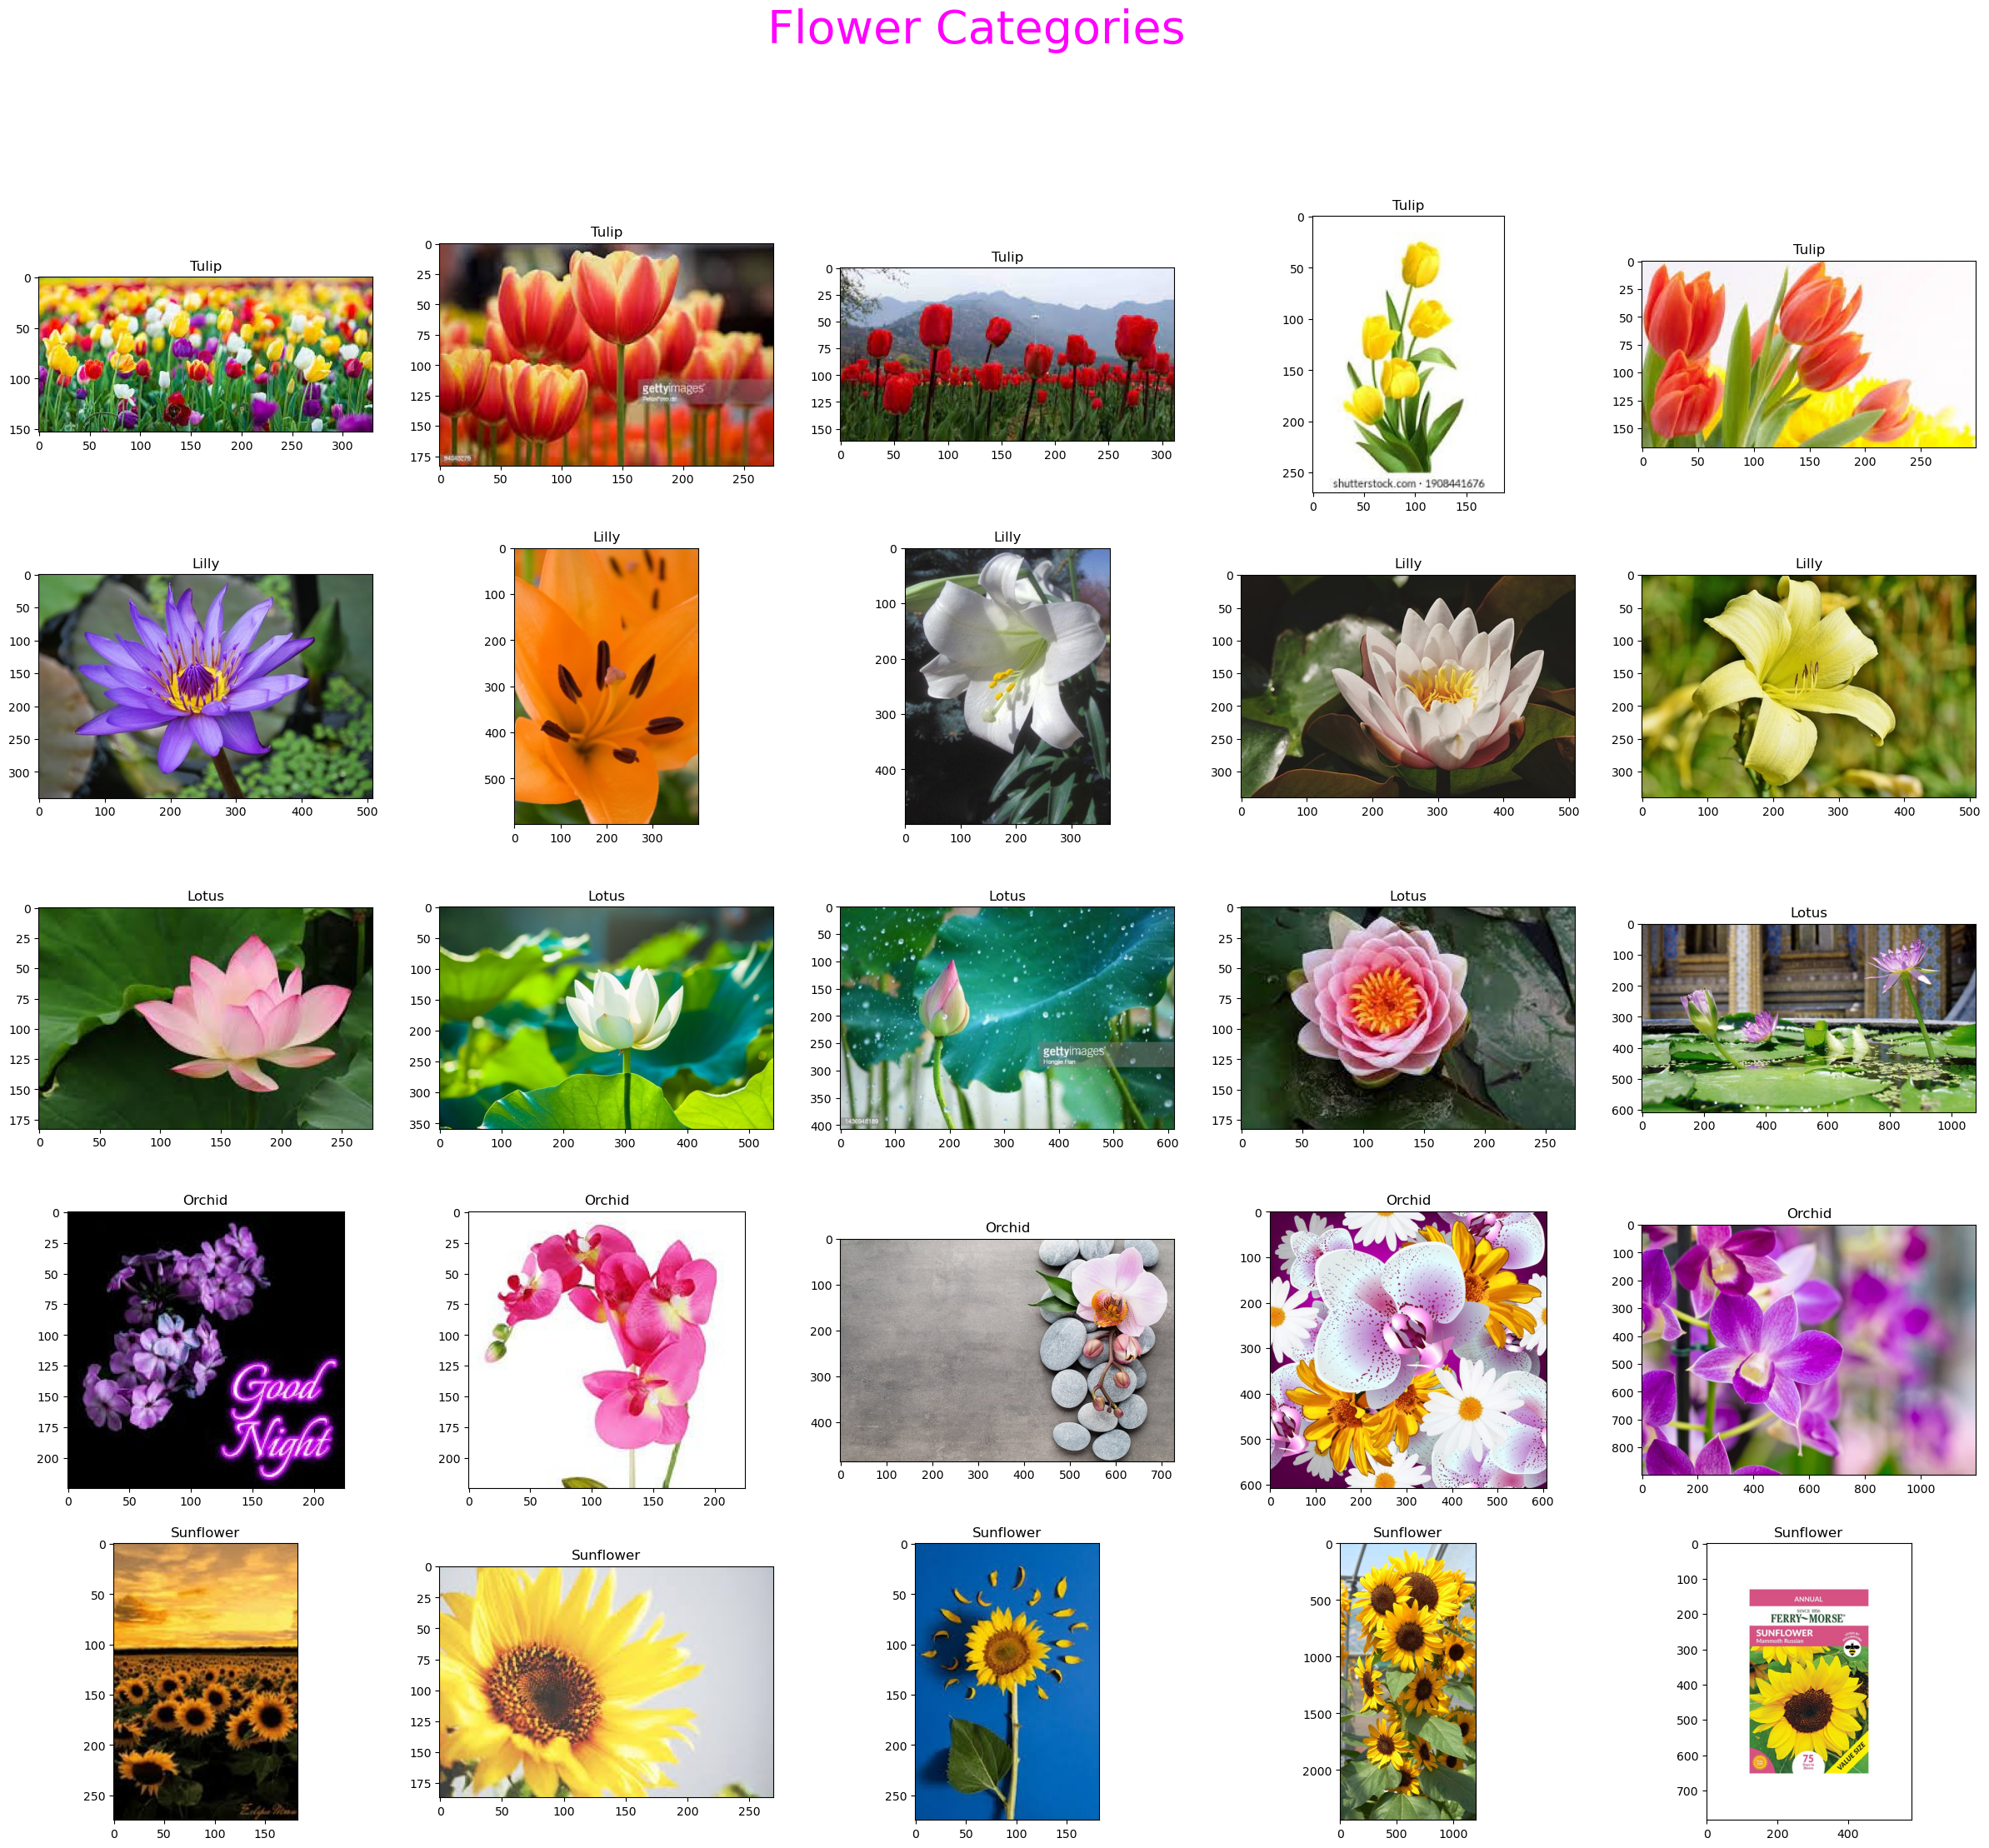

In [4]:
fig, ax = plt.subplots(5,5, figsize=(30,25))
fig.suptitle('Flower Categories',color='magenta',fontsize=40)
for i in range(5):
    for j in range(5):
        im_src = rootdir +'train/' + classes_dir[i] + '/'
        FileNames = os.listdir(im_src)
        im_src = str(im_src + FileNames[j])       
        imag = img.imread(im_src)
        ax[i, j].imshow(imag)
        ax[i, j].set_title(classes_dir[i])

## Data Augmentation of Train and Test Sets
Data augmentation is applied to the train and test sets using the ImageDataGenerator class from Keras. Data augmentation techniques such as rotation, shift, shear, zoom, and horizontal flip are applied to the images. These techniques help increase the diversity and size of the training data, leading to better model performance.


In [5]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
# test Data Augmentation 
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

## Train and Test and DataSet Generation

The train and test sets are generated using the flow_from_directory method of the ImageDataGenerator class. The target size is set to (224, 224), which is the input size expected by the VGG16 model. The batch size is set to 32, and the class mode is set to 'categorical'.


In [6]:
train_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 4000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


## VGG16 Parameter Setting and Downloading

The VGG16 model is initialized with the input shape as (256, 256, 3) and weights set to 'imagenet'. This downloads the pre-trained weights of the VGG16 model trained on the ImageNet dataset.


In [7]:
IMAGE_SIZE = [224, 224, 3]
base_model = VGG16(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


## Freezing the Parameters and Input Checking
 

The parameters of the VGG16 model are frozen to prevent them from being updated during training. The model's input layer is checked to ensure the correct input shape.


In [8]:
base_model.input
base_model.trainable = False


## Connecting VGG output with User Generated Model 
The output of the VGG16 model is connected to a GlobalAveragePooling2D layer, which reduces the spatial dimensions of the output. The output of the GlobalAveragePooling2D layer is then connected to a Dense layer with softmax activation. This Dense layer has 5 units, representing the 5 flower categories.


In [9]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(5, activation = 'softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 2565      
                                                                 
Total params: 14,717,253
Trainable params: 2,565
Non-trainable params: 14,714,688
_________________________________________________________________


## Compiling and Setting loss function and Optimizer 
The model is compiled with the categorical_crossentropy loss function and the Adam optimizer. Categorical cross-entropy is commonly used for multi-class classification tasks. Adam is an optimization algorithm that adapts the learning rate during training.


In [10]:
adam = optimizers.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

## Start Training and Collecting best points 
The model is trained using the fit method. The training data is provided by the train_set generator, and the validation data is provided by the test_set generator. The training process is run for 15 epochs with a batch size of 32. The ModelCheckpoint callback is used to save the best model based on the validation accuracy.


In [11]:
checkpoint = ModelCheckpoint(filepath='mymodel.h5', 
                               verbose=2, save_best_only=True)
callbacks = [checkpoint]
start = datetime.now()

model_history=model.fit(
                      train_set,
                      validation_data=test_set,
                      epochs=20,
                      validation_steps=32,
                      callbacks=callbacks ,verbose=2)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/20

Epoch 1: val_loss improved from inf to 1.30374, saving model to mymodel.h5
125/125 - 85s - loss: 2.5125 - accuracy: 0.4622 - val_loss: 1.3037 - val_accuracy: 0.6470 - 85s/epoch - 677ms/step
Epoch 2/20

Epoch 2: val_loss improved from 1.30374 to 0.93007, saving model to mymodel.h5
125/125 - 70s - loss: 1.1258 - accuracy: 0.6745 - val_loss: 0.9301 - val_accuracy: 0.7150 - 70s/epoch - 563ms/step
Epoch 3/20

Epoch 3: val_loss improved from 0.93007 to 0.81932, saving model to mymodel.h5
125/125 - 71s - loss: 0.8574 - accuracy: 0.7265 - val_loss: 0.8193 - val_accuracy: 0.7580 - 71s/epoch - 567ms/step
Epoch 4/20

Epoch 4: val_loss improved from 0.81932 to 0.72751, saving model to mymodel.h5
125/125 - 70s - loss: 0.7453 - accuracy: 0.7577 - val_loss: 0.7275 - val_accuracy: 0.7630 - 70s/epoch - 562ms/step
Epoch 5/20

Epoch 5: val_loss improved from 0.72751 to 0.65769, saving model to mymodel.h5
125/125 - 70s - loss: 0.6665 - accuracy: 0.7685 - val_loss: 0.6577 - val_accuracy: 0.7670

## Plotting the Accuracy of the Model Before Fine tunning

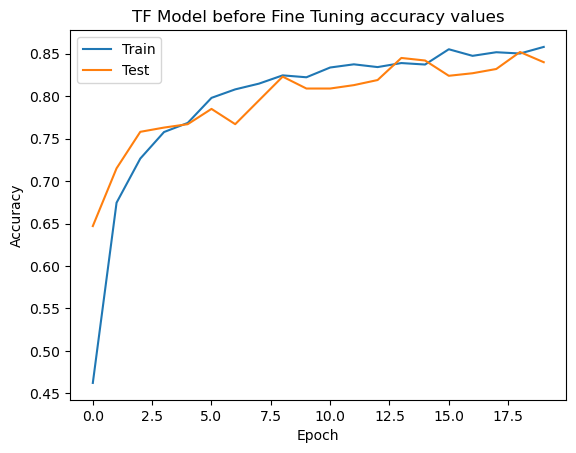

In [12]:
_# Plot training & validation loss values
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('TF Model before Fine Tuning accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


## Plot training & validation loss values before Fine Tunning



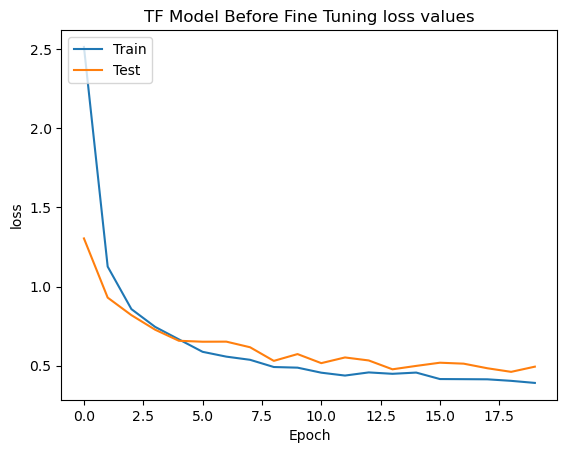

In [13]:
_# Plot training & validation loss values
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('TF Model Before Fine Tuning loss values')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


## Do a round of fine-tuning of the entire model
Finally, let's unfreeze the base model and train the entire model end-to-end with a low learning rate.
The base_model parameters are unfrozen to allow fine-tuning of the entire model.A new Adam optimizer is created with a lower learning rate (1e-5) for fine-tuning. The model is compiled again with the new optimizer.


In [14]:
base_model.trainable = True
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 2565      
                                                                 
Total params: 14,717,253
Trainable params: 14,717,253
Non-trainable params: 0
_________________________________________________________________


In [15]:
adam = optimizers.Adam(1e-5)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

## Importantly
Here although the base model becomes trainable, it is still running in inference mode since we passed training=False when calling it when we built the model. This means that the batch normalization layers inside won't update their batch statistics. If they did, they would wreck havoc on the representations learned by the model so far.

In [16]:
checkpoint = ModelCheckpoint(filepath='mymodel.h5', 
                               verbose=2, save_best_only=True)
callbacks = [checkpoint]
start = datetime.now()

model_history=model.fit(
                      train_set,
                      validation_data=test_set,
                      epochs=20,
                     # steps_per_epoch=140,
                      validation_steps=32,
                      callbacks=callbacks ,verbose=2)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/20

Epoch 1: val_loss improved from inf to 0.34600, saving model to mymodel.h5
125/125 - 99s - loss: 0.3822 - accuracy: 0.8652 - val_loss: 0.3460 - val_accuracy: 0.8900 - 99s/epoch - 790ms/step
Epoch 2/20

Epoch 2: val_loss improved from 0.34600 to 0.34042, saving model to mymodel.h5
125/125 - 84s - loss: 0.2720 - accuracy: 0.9028 - val_loss: 0.3404 - val_accuracy: 0.8900 - 84s/epoch - 675ms/step
Epoch 3/20

Epoch 3: val_loss improved from 0.34042 to 0.28023, saving model to mymodel.h5
125/125 - 84s - loss: 0.2086 - accuracy: 0.9302 - val_loss: 0.2802 - val_accuracy: 0.9090 - 84s/epoch - 669ms/step
Epoch 4/20

Epoch 4: val_loss did not improve from 0.28023
125/125 - 91s - loss: 0.1756 - accuracy: 0.9398 - val_loss: 0.3026 - val_accuracy: 0.9050 - 91s/epoch - 728ms/step
Epoch 5/20

Epoch 5: val_loss improved from 0.28023 to 0.22664, saving model to mymodel.h5
125/125 - 85s - loss: 0.1514 - accuracy: 0.9477 - val_loss: 0.2266 - val_accuracy: 0.9290 - 85s/epoch - 677ms/step
Epoch 

## Plotting the Accuracy of the Model After Fine tunning
The accuracy values of the model on the training and test sets are plotted over epochs. This helps visualize the improvement of the model's accuracy during training.


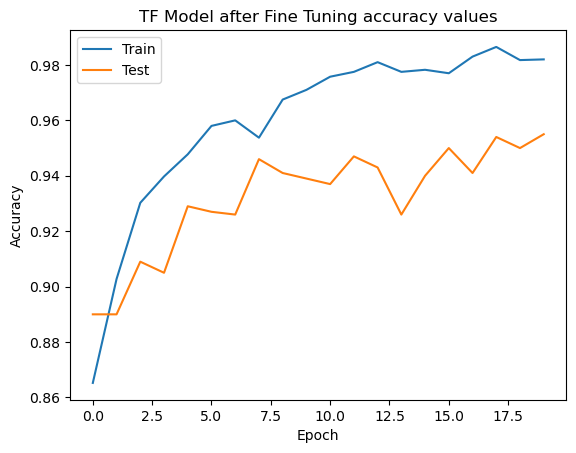

In [17]:
_# Plot training & validation loss values
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('TF Model after Fine Tuning accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


## Plotting the Loss values of the Model
The loss values of the model on the training and test sets are plotted over epochs. This helps visualize the convergence of the model's loss during training.


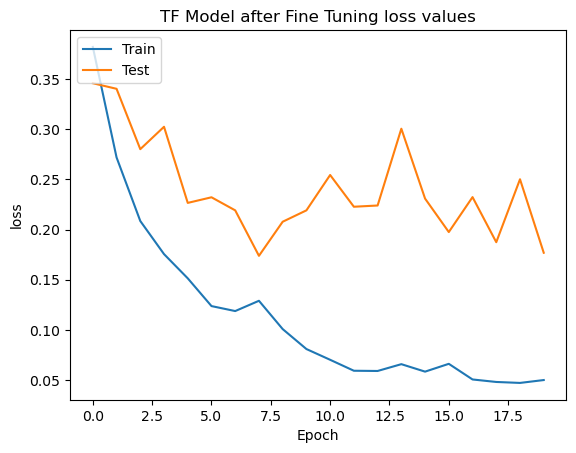

In [18]:
_# Plot training & validation loss values
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('TF Model after Fine Tuning loss values')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


## Importent Note
IF you find any difficulty feel free to ask me 
After 10 epochs,  fine-tuning gains us a nice improvement here.



## Conclusion:

In this project, we implemented a flower classification model using transfer learning with the VGG16 architecture. The goal was to classify images of different flower types into five categories: Tulip, Lilly, Lotus, Orchid, and Sunflower.


After training the model for 20 epochs, we achieved an impressive training accuracy of 84% and a validation accuracy of 83%. These high accuracy scores indicate that the model has learned to accurately classify flower images.

Furthermore, we performed fine-tuning of the model by unfreezing the base model parameters and training the entire model for an additional 15 epochs with a lower learning rate. This process further improved the model's performance and fine-tuned its learned representations.

Overall, this project demonstrates the effectiveness of transfer learning and the VGG16 architecture for flower classification tasks. The achieved accuracy scores of 98% for training accuracy and 95% for validation accuracy validate the model's capability to accurately classify flower images. With further optimization and experimentation, it is possible to improve the model's performance even more.

This flower classification model can be a valuable tool for various applications, such as botanical research, e-commerce platforms, or educational purposes. It showcases the power of deep learning and transfer learning in solving real-world image classification problems.